In [1]:
%run [YJ]Samsung.Step2_3_MakeValidationSet.ipynb

In [5]:
from pomegranate import *
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pygraphviz
from sklearn.preprocessing import LabelEncoder

## Split train validation set

In [6]:
df.shape

(25037, 37)

In [7]:
np.random.seed(100)
chosen_idx = np.random.choice(len(df), replace=False, size=int(len(df) * 0.8))

df_train = df.iloc[chosen_idx]
df_test = df.iloc[np.setdiff1d(df.index, chosen_idx)]

In [8]:
df_train.shape, df_test.shape

((20029, 37), (5008, 37))

In [9]:
df_train['type'] = 'train'
df_test['type'] = 'test'

df_concat = pd.concat([df_train, df_test])
df_concat.shape, df_train.shape, df_test.shape

/Users/youngjun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/youngjun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


((25037, 38), (20029, 38), (5008, 38))

## Mapping, Encoding, Decoding

In [11]:
def get_cat_mapping_set(df):
    cat_mapping_set = {}
    columns = ['주야', '요일','발생지시도', '발생지시군구','사고유형_대분류', 
               '사고유형_중분류', '법규위반', '도로형태_대분류', '도로형태', 
               '당사자종별_1당_대분류','당사자종별_2당_대분류', '발생지']
    for col in columns:
        le = LabelEncoder()
        result = le.fit(df[col])    
        cat_mapping_set[col] = result
    
    return cat_mapping_set


def encode_df(df, cat_mapping_set):
    
    tmp_dic_lst = []
    
    columns = ['주야', '요일','발생지시도', '발생지시군구','사고유형_대분류', 
               '사고유형_중분류', '법규위반', '도로형태_대분류', '도로형태', 
               '당사자종별_1당_대분류','당사자종별_2당_대분류', '발생지']
    
    for col in columns:
        tmp_dic_lst.append(cat_mapping_set[col].transform(df[col]))
    
    tmp_dic_lst = np.array(tmp_dic_lst)    
    combined_df_encoded = pd.DataFrame(np.matrix(tmp_dic_lst.T), columns=columns)
    
    for col in columns:
        df[col] = combined_df_encoded[col]
    
    return df

def decode_df(df_encoded, cat_mapping_set):
    
    tmp_dic_lst = []
    columns = ['주야', '요일','발생지시도', '발생지시군구','사고유형_대분류', 
               '사고유형_중분류', '법규위반', '도로형태_대분류', '도로형태', 
               '당사자종별_1당_대분류','당사자종별_2당_대분류', '발생지']
    
    for col in columns:
        tmp_dic_lst.append(cat_mapping_set[col].inverse_transform(df_encoded[col]))
    
    tmp_dic_lst = np.array(tmp_dic_lst)  
    combined_df_decoded = pd.DataFrame(np.matrix(tmp_dic_lst.T), columns=columns) 
    
    for col in columns:
        df_encoded[col] = combined_df_decoded[col]
    
    return df_encoded

## type 설정

In [12]:
col_order = df.columns

In [13]:
dict_var={}
for i,c in enumerate(col_order):
    dict_var[c] = i
    
type_1 = [
    dict_var['발생지시도'], 
    dict_var['발생지시군구'], 
    dict_var['발생지'], 
    dict_var['발생지시도x요일x주야_위험도'],     
    dict_var['노인피해'],
    dict_var['노인건수'],
    dict_var['어린이피해'],
    dict_var['어린이건수'],
    dict_var['자전거피해'],
    dict_var['자전거건수'],
    dict_var['무단횡단피해'],
    dict_var['무단횡단건수'],
    dict_var['학교피해'],
    dict_var['학교건수'],
    dict_var['요일_사고유형_NMF1'],
    dict_var['요일_사고유형_NMF2'],
    dict_var['요일_사고유형_NMF3']
]
type_2 = [dict_var['사고유형_대분류'], dict_var['사고유형_중분류'], dict_var['법규위반'], dict_var['사고유형_위험도']]
type_3 = [dict_var['요일'], dict_var['사고유형_대분류'], dict_var['사고유형_중분류'], dict_var['발생지시도x요일x주야_위험도']]
type_4 = [dict_var['요일'], dict_var['사고유형_중분류'], dict_var['법규위반'], dict_var['도로형태_대분류'], dict_var['발생지시도x요일x주야_위험도'], dict_var['사고유형_위험도']]
type_5 = [dict_var['도로형태_대분류'], dict_var['도로형태'], dict_var['당사자종별_1당_대분류'], dict_var['당사자종별_2당_대분류'], dict_var['차량조합_위험도']]
type_6 = [dict_var['도로형태_대분류'], dict_var['도로형태'], dict_var['당사자종별_1당_대분류'], dict_var['차량조합_위험도']]
type_7 = [dict_var['도로형태_대분류'], dict_var['도로형태'], dict_var['당사자종별_2당_대분류'], dict_var['차량조합_위험도'] ]
type_8 = [dict_var['주야'], dict_var['당사자종별_1당_대분류'], dict_var['발생지시도x요일x주야_위험도'], dict_var['차량조합_위험도']]
type_9 = [dict_var['주야'], dict_var['도로형태'], dict_var['발생지시도x요일x주야_위험도']]
type_10 = [
    dict_var['발생지시군구'], 
    dict_var['발생지'], 
    dict_var['발생지시도x요일x주야_위험도'],    
    dict_var['노인피해'],
    dict_var['노인건수'],
    dict_var['어린이피해'],
    dict_var['어린이건수'],
    dict_var['자전거피해'],
    dict_var['자전거건수'],
    dict_var['무단횡단피해'],
    dict_var['무단횡단건수'],
    dict_var['학교피해'],
    dict_var['학교건수'],
    dict_var['요일_사고유형_NMF1'],
    dict_var['요일_사고유형_NMF2'],
    dict_var['요일_사고유형_NMF3'],
]

type_11 = [dict_var['사망자수'], dict_var['사상자수'], dict_var['경상자수']]
type_12 = [dict_var['사상자수'], dict_var['중상자수'], dict_var['부상신고자수']]
type_13 = [dict_var['사상자수'], dict_var['중상자수'], dict_var['경상자수']]
type_14 = [dict_var['사망자수'], dict_var['중상자수'], dict_var['사상자수']]
type_15 = [dict_var['사망자수'], dict_var['사상자수'], dict_var['발생지시군구']]
type_16 = [dict_var['중상자수'], dict_var['경상자수'], dict_var['발생지시군구']]
type_17 = [dict_var['주야'], dict_var['사망자수'], dict_var['사상자수'], dict_var['당사자종별_1당_대분류']]
type_18 = [dict_var['주야'], dict_var['사상자수'], dict_var['중상자수'], dict_var['도로형태']]

## Bayesian Network

#### binning1

In [14]:
df_binned = binning1(df_concat)
df_binned.shape

(25037, 38)

In [15]:
col_names = df_binned.columns
col_names

Index(['주야', '요일', '사망자수', '사상자수', '중상자수', '경상자수', '부상신고자수', '발생지시도', '발생지시군구',
       '사고유형_대분류', '사고유형_중분류', '법규위반', '도로형태_대분류', '도로형태', '당사자종별_1당_대분류',
       '당사자종별_2당_대분류', '발생지', '총길이', '제한속도', '무단횡단피해', '무단횡단건수', '노인피해',
       '노인건수', '어린이피해', '어린이건수', '자전거피해', '자전거건수', '학교피해', '학교건수',
       '요일_사고유형_NMF1', '요일_사고유형_NMF2', '요일_사고유형_NMF3', '발생지시군구_위험도',
       '발생지시도x요일x주야_위험도', '차량조합_위험도', '사고유형_위험도', '위험도평균', 'type'],
      dtype='object')

In [16]:
cat_mapping_set = get_cat_mapping_set(df_binned)
df_encoded = encode_df(df_binned, cat_mapping_set)

df_encoded.shape

In [19]:
test = df_encoded.loc[df_encoded.type == 'test']
train = df_encoded.loc[df_encoded.type == 'train']

train.shape, test.shape

In [21]:
train.drop(columns=['type'], inplace=True)
test.drop(columns=['type'], inplace=True)

/Users/youngjun/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [22]:
train_dum = train[col_order]
test_dum = test[col_order]

In [23]:
for col in col_order:
    diff_arr = np.setdiff1d(test_dum[col].unique(), train_dum[col].unique())
    test_dum = test_dum.loc[~test_dum[col].isin(diff_arr),:]

In [24]:
auto_chow_net = BayesianNetwork.from_samples(train_dum.iloc[:,:].as_matrix(), algorithm='chow-liu', n_jobs=-1)


/Users/youngjun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [50]:
types = [type_1, type_2, type_3, type_4, type_5, type_6, type_7, type_8, type_9, type_10]

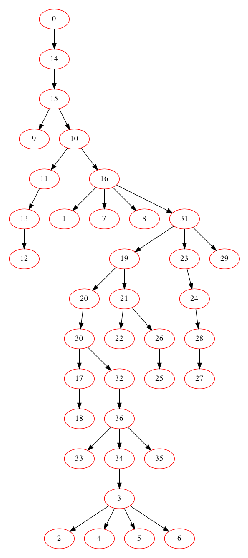

In [26]:
plt.figure(figsize=(100, 10))
auto_chow_net.plot()

In [ ]:
def run_model_auto_chow_mat(type_q, test_dum=test_dum, n_rows=30):
    select_cols = np.array(col_order)[type_q]
    test_dum2 = test_dum.copy()
    problem_dum = test_dum2.copy()
    problem_dum[select_cols] = None
    problem_mat = problem_dum.as_matrix()
    result = auto_chow_net.predict(problem_mat[:n_rows, :], n_jobs=-1)
    n_incorrect = np.sum(test_dum2.as_matrix()[:n_rows,:] != np.matrix(result))
    n_total = n_rows * len(type_q)
#     dic = dict()
#     dic[type_q] = 
    return (type_q, (n_total - n_incorrect) / n_total)

In [29]:
result_arr = [run_model_auto_chow_mat(type_q) for type_q in types]


/Users/youngjun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/youngjun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [30]:
result_arr

[([7, 8, 16, 33, 21, 22, 23, 24, 25, 26, 19, 20, 27, 28, 29, 30, 31],
  0.3196078431372549),
 ([9, 10, 11, 35], 0.7),
 ([1, 9, 10, 33], 0.5333333333333333),
 ([1, 10, 11, 12, 33, 35], 0.5777777777777777),
 ([12, 13, 14, 15, 34], 0.6666666666666666),
 ([12, 13, 14, 34], 0.6333333333333333),
 ([12, 13, 15, 34], 0.7),
 ([0, 14, 33, 34], 0.5416666666666666),
 ([0, 13, 33], 0.6888888888888889),
 ([8, 16, 33, 21, 22, 23, 24, 25, 26, 19, 20, 27, 28, 29, 30, 31],
  0.3458333333333333)]

### binning3

In [32]:
df_binned = binning3(df_concat)
df_binned.shape

(25037, 38)

In [34]:
cat_mapping_set = get_cat_mapping_set(df_binned)
df_encoded = encode_df(df_binned, cat_mapping_set)

df_encoded.shape

(25037, 38)

In [35]:
test = df_encoded.loc[df_encoded.type == 'test']
train = df_encoded.loc[df_encoded.type == 'train']

train.shape, test.shape

((20029, 38), (5008, 38))

In [36]:
train.drop(columns=['type'], inplace=True)
test.drop(columns=['type'], inplace=True)

In [40]:
train_dum = train[col_order]
test_dum = test[col_order]

In [48]:
for col in col_order:
    diff_arr = np.setdiff1d(test_dum[col].unique(), train_dum[col].unique())
    test_dum = test_dum.loc[~test_dum[col].isin(diff_arr),:]

In [49]:
auto_chow_net = BayesianNetwork.from_samples(train_dum.iloc[:,:].as_matrix(), algorithm='chow-liu', n_jobs=-1)


/Users/youngjun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [51]:
types = [type_1, type_2, type_3, type_4, type_5, type_6, type_7, type_8, type_9, type_10]

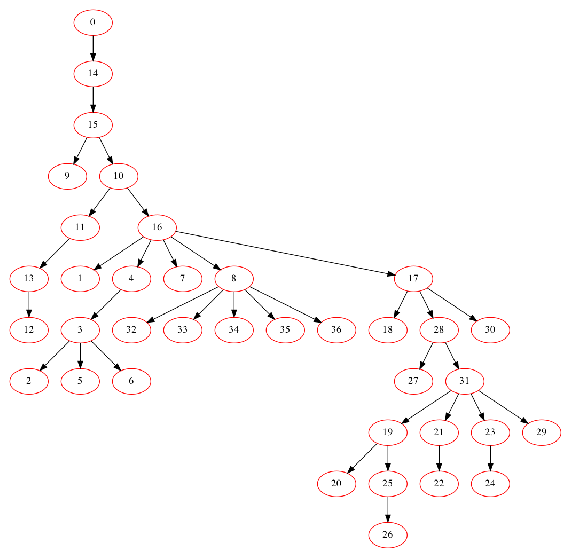

In [52]:
plt.figure(figsize=(100, 10))
auto_chow_net.plot()

In [54]:
def run_model_auto_chow_mat(type_q, test_dum=test_dum, n_rows=30):
    select_cols = np.array(col_order)[type_q]
    test_dum2 = test_dum.copy()
    problem_dum = test_dum2.copy()
    problem_dum[select_cols] = None
    problem_mat = problem_dum.as_matrix()
    result = auto_chow_net.predict(problem_mat[:n_rows, :], n_jobs=-1)
    n_incorrect = np.sum(test_dum2.as_matrix()[:n_rows,:] != np.matrix(result))
    n_total = n_rows * len(type_q)
#     dic = dict()
#     dic[type_q] = 
    return (type_q, (n_total - n_incorrect) / n_total)

In [55]:
result_arr = [run_model_auto_chow_mat(type_q) for type_q in types]


/Users/youngjun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/youngjun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [56]:
result_arr

[([7, 8, 16, 33, 21, 22, 23, 24, 25, 26, 19, 20, 27, 28, 29, 30, 31],
  0.5725490196078431),
 ([9, 10, 11, 35], 0.8416666666666667),
 ([1, 9, 10, 33], 0.6833333333333333),
 ([1, 10, 11, 12, 33, 35], 0.7666666666666667),
 ([12, 13, 14, 15, 34], 0.8133333333333334),
 ([12, 13, 14, 34], 0.8166666666666667),
 ([12, 13, 15, 34], 0.8833333333333333),
 ([0, 14, 33, 34], 0.7916666666666666),
 ([0, 13, 33], 0.8777777777777778),
 ([8, 16, 33, 21, 22, 23, 24, 25, 26, 19, 20, 27, 28, 29, 30, 31], 0.60625)]

In [59]:
train_dum.columns

Index(['주야', '요일', '사망자수', '사상자수', '중상자수', '경상자수', '부상신고자수', '발생지시도', '발생지시군구',
       '사고유형_대분류', '사고유형_중분류', '법규위반', '도로형태_대분류', '도로형태', '당사자종별_1당_대분류',
       '당사자종별_2당_대분류', '발생지', '총길이', '제한속도', '무단횡단피해', '무단횡단건수', '노인피해',
       '노인건수', '어린이피해', '어린이건수', '자전거피해', '자전거건수', '학교피해', '학교건수',
       '요일_사고유형_NMF1', '요일_사고유형_NMF2', '요일_사고유형_NMF3', '발생지시군구_위험도',
       '발생지시도x요일x주야_위험도', '차량조합_위험도', '사고유형_위험도', '위험도평균'],
      dtype='object')

In [ ]:
# 입력 변수: 주야, 요일, 발생지시도, 발생지시군구, 차량 대분류 -> 발생지, 총길이, 제한속도, 무단횡단피해, 무단횡단건수, 노인피해, 노인건수, 어린이피해, 어린이건수,. 자전거피해,자전거건수,학교피해,학교건수, 발생지시군구 위험도 발생지시도 요일 주야 위험도
# 추가 변수: 법규위반, 도로형태 대분류, 도로형태, 
# 피룡없음: 당사자종별 1당, 2당 대분류, nmf123변수

#입력변수 입력받으면
#1. 내가 사고 냈을 때 : 상대 차종별 차량조합 위험도 get/위험도 평균 get
#2. 내가 사고 당했을 때: 상대 차종별 차량조합 위험도 get/위험도 평균 get

# 카테고리 다 get 한 후, 사상자수 추정 by randomforest + knn

